This notebook is a part of the Optical Tweezers experiment data anaysis procedure (Sebastian Kalos, Tengiz Ibrayev, March/ April 2021). In this part, we are forcing stage motion with a sample of FREE beads (1 or 2.12 microns diameter) along one axis and measuring the bead's displacement from the trap's center (using QPD sensitivity obtained in another jupyter notebook) during a time period in which the stage is moving at a constant speed. Assuming that stokes drag force is equal to the restoring force of the trap, we calculate the trap's stifness constant (at specific laser power)

In [2998]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import scipy
import statistics

In [3159]:
xls_file = pd.ExcelFile("STOKES_1micron_mar22.xlsx") #just load the excel file containing STOKES data (TAKES TIME, DO NOT WORRY)

In [3160]:
#reading each sheet into a data frame (TAKES TIME AS WELL)
df_150mA = pd.read_excel(xls_file, '150mA')
df_200mA = pd.read_excel(xls_file, '200mA')
df_250mA = pd.read_excel(xls_file, '250mA')
df_300mA = pd.read_excel(xls_file, '300mA')
df_350mA = pd.read_excel(xls_file, '350mA')
df_400mA = pd.read_excel(xls_file, '400mA')

In [3301]:
#GLOBAL VARIABLES
frequency = 20 #Hz, frequency of oscillation we are forcing (triangular voltage input)
meas_len = 5 #5 seconds of measurement
time_display_start = 0 #x-axis start of all plots
time_display_stop = 0.2 #x-axis limit for all plots

viscosity = 0.000954 #pN*s/micron^2 at 22 deg. Celsius
viscosity_err = 0.0001

bead_diameter = 1.0 #microns
bead_diam_err = 0.1

workbook_name = "tweezers_data.xlsx" #name of the excel file containing QPD sensitivity data
sheet_name = '1micron' #name of the excel file's sheet 

picked_power = 400 #mA; this run is specific for this laser current!

In [3302]:
# notebook Tweezers_QPD was run for every laser power and bead diameter and sensitivity for each recorded in an Excel file
# Here I load these sensitivities from that file (just one bead size though) and plot them:
tweezers_data_file = pd.ExcelFile(workbook_name)
df_tweezers = pd.read_excel(tweezers_data_file, sheet_name)
arr_tweezers = df_tweezers.to_numpy()
qpd_laser_powers = arr_tweezers[:,0]
qpd_sens_avg = arr_tweezers[:,1]
qpd_sens_STDEV = arr_tweezers[:,4]

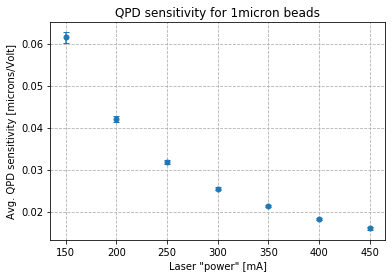

In [3303]:
#Plot avg. QPD sensitivity as a function of laser power - 
plt.errorbar(qpd_laser_powers, qpd_sens_avg, qpd_sens_STDEV, fmt='o', markersize=5, capsize=3)
plt.xlabel('Laser "power" [mA]')
plt.ylabel('Avg. QPD sensitivity [microns/Volt]')
plt.title("QPD sensitivity for " + sheet_name + " beads")
plt.grid(linestyle='--')

In [3304]:
n_of_datapoints = len(df_150mA.index) #how many time values are taken?
time = np.arange(0,meas_len,meas_len/n_of_datapoints) #create a new array with time series

In [3305]:
#convert STOKES measurement dataframe to numpy arrays (I lowkey hate to work with this dataframe format)
arr_150mA = df_150mA.to_numpy()
arr_200mA = df_200mA.to_numpy()
arr_250mA = df_250mA.to_numpy()
arr_300mA = df_300mA.to_numpy()
arr_350mA = df_350mA.to_numpy()
arr_400mA = df_400mA.to_numpy()

In [3306]:
stokes_laser_powers = np.array([150, 200, 250, 300, 350, 400]) #these are the laser "powers" (actually currents) that we used

#these lines just allow me to change one global variable (laser current) so that picking the right sheet is automated
laser_power_index = int(np.where(stokes_laser_powers == picked_power)[0])
laser_power_arrays = [arr_150mA, arr_200mA, arr_250mA, arr_300mA, arr_350mA, arr_400mA]
picked_dev = laser_power_arrays[laser_power_index]

In [3307]:
#extract voltage columns from the np array containing data series from all devices
qpd_x = picked_dev[:,0] #qpd along x-axis
qpd_y = picked_dev[:,1]
qpd_z = picked_dev[:,2]

pos_x = picked_dev[:,3] #voltage data from the strain gauge - along x-axis
pos_y = picked_dev[:,4]

Text(0, 0.5, 'QPD voltage (V)')

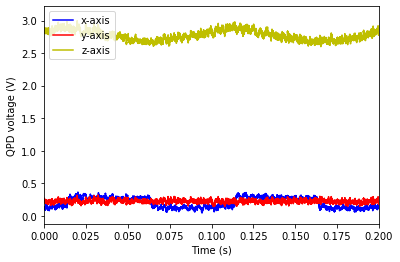

In [3308]:
#just plotting qpd voltage data versus time here
plt.plot(time, qpd_x, 'b', label='x-axis')
plt.plot(time, qpd_y, 'r', label='y-axis')
plt.plot(time, qpd_z, 'y', label='z-axis')
plt.legend(loc="upper left")
plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time (s)')
plt.ylabel('QPD voltage (V)')

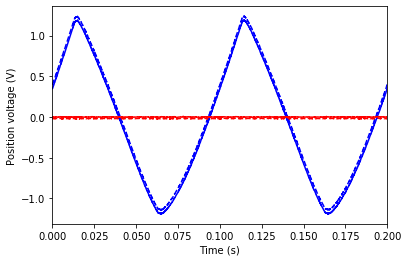

In [3309]:
#plotting voltage data from the position stage (both axes) and correcting its offset

plt.plot(time, pos_x, '--b')
plt.plot(time, pos_y, '--r')
plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time (s)')
plt.ylabel('Position voltage (V)')

#the voltage has an obvious offset - following lines center it on zero pos. voltage
x_offset = max(pos_x)-(max(pos_x)-min(pos_x))/2
pos_x_center = pos_x - x_offset

y_offset = max(pos_y)-(max(pos_y)-min(pos_y))/2
pos_y_center = pos_y - y_offset

#plot again the corrected signal:
plt.plot(time, pos_x_center, 'b')
plt.plot(time, pos_y_center, 'r')

In [3310]:
#from now on, only one axis is being studied.
qpd_voltage = qpd_x

stage voltage to displacement conversion factor (microns per volt):  0.1976138709494138


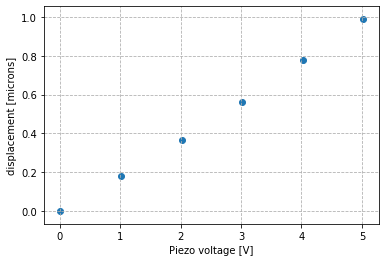

In [3311]:
#now I want to convert pos. voltage to actual displacement:
# for this measurement, we simply took a series of values manually (moving with the stage manually and recording strain gauge readings)
disp_volt = [0, 1.02, 2.02, 3.02, 4.02, 5.02] #taken manually
disp_microns = [0, 0.179, 0.365, 0.560, 0.778, 0.989] #taken manually (avg. of x, y motion)
plt.scatter(disp_volt, disp_microns)
plt.xlabel('Piezo voltage [V]')
plt.ylabel('displacement [microns]')
plt.grid(linestyle='--')
stage_microns_per_volt,b = np.polyfit(disp_volt, disp_microns, 1) #do a linear fit and find slope ("microns per volt")
print("stage voltage to displacement conversion factor (microns per volt): ", stage_microns_per_volt)

In [3312]:
def hysteresis(zero_crossings):

# here I'm cleaning up a bit and defining a function that becomes useful in a moment:

# e.g. in the qpd voltage data, zero crossings are not "clean" - there are multiple time instances (often temporally close to each other) at which the voltage crosses 0 (due to noise). Finding zero-crossings becomes important, however, and I want to avoid duplicates.
# This function takes an array that contains indices of zero-crossings of some signal. I find the periodic pattern and the number of steps it takes to cross zero.
# if the number of time steps is lower than half of the "average", I delete the redundant zero crossing index


    interval_diffs = []
    for i in range(0, len(zero_crossings)-1): #start with second zero-crossing index and find its distance from the previous one
        diff = zero_crossings[i+1] - zero_crossings[i]
        interval_diffs.append(diff) #For each index, store its distance from the previous
    interval_diffs = np.array(interval_diffs)
    avg_diffs = np.average(interval_diffs) #find the "average" width of the signal (it's NOT the average width though, just an orientation number to decide which ones to kick out!)

    indices_to_delete = []
    #scan through the qpd crossing indices again, now knowing what width each pulse should exceed and store the redundant indices 
    for i in range(0, len(zero_crossings)-1):
        diff = zero_crossings[i+1] - zero_crossings[i]
        if diff <= avg_diffs/2:
            indices_to_delete.append(i)

    zero_crossings = np.delete(zero_crossings, indices_to_delete) #delete redundant zero-crossing indices
    return(zero_crossings)

In [3313]:
def find_extrema(voltage_data, time):
# this function takes in qpd voltage array, time series array and returns arrays containing spikes in the voltage data (maxima, minima),
# indices of zero-crossings (up and down separately), and the total number of extremum points (positive OR negative spikes, whichever is smaller)

    voltage_zero_crossings = np.where(np.diff(np.sign(voltage_data)))[0] #get an array of indices at which a sign change occurs in the voltage signal

    voltage_zero_crossings = hysteresis(voltage_zero_crossings)

    global_max_voltage = max(voltage_data) #overall maximum of voltage signal
    global_min_voltage = min(voltage_data) #overall minimum of voltage signal
        
    maxima = []
    minima = []
    up_indices = []
    down_indices = []

    ## search for one local min and one max starts here
    for i in range(0, len(voltage_zero_crossings)-1):
        crossing_index = voltage_zero_crossings[i] 
        next_crossing = voltage_zero_crossings[i+1]
        previous_crossing = voltage_zero_crossings[i-1]

        local_max_voltage = 0
        local_max_index = 0

        local_min_voltage = 0
        local_min_index = 0

        flag1 = 0
        flag2 = 0

        threshold = 4/5 #this times the global max is the threshold for deciding if a peak is a local max. 

        #find index of local max around zero crossing
        for j in range(previous_crossing+1, next_crossing-1): #scan from last to next
            if voltage_data[j] > local_max_voltage and voltage_data[j] > global_max_voltage * threshold: 
                local_max_voltage = voltage_data[j]
                local_max_index = j
                flag1 = -1

        #find index of local min around zero crossing
        for k in list(reversed(range(previous_crossing+1, next_crossing-1))):
            if voltage_data[k] < local_min_voltage and voltage_data[k] < global_min_voltage * threshold:
                local_min_voltage = voltage_data[k]
                local_min_index = k
                flag2 = -1

        flag = flag1*flag2
        if local_max_voltage > 0:
            if [local_max_index, local_max_voltage] not in maxima:
                maxima.append([local_max_index, local_max_voltage])
        if local_min_voltage < 0:
            if [local_min_index, local_min_voltage] not in minima:
                minima.append([local_min_index, local_min_voltage])

        if flag and local_max_index > crossing_index and local_min_index < crossing_index:
            up_indices.append(crossing_index)
        elif flag and local_max_index < crossing_index and local_min_index > crossing_index:
            down_indices.append(crossing_index)



    if len(minima) < len(maxima):
        n_of_extrema = len(minima)
    else: 
        n_of_extrema = len(maxima)

    return([maxima, minima, up_indices, down_indices, n_of_extrema])

In [3314]:
#transforming stage motion data from "voltage vs time" into "displacement versus time" (in microns) using the above slope
displac = pos_x_center * stage_microns_per_volt 

In [3315]:
#calling a custom function to find maxima, minima, zero crossings etc. of the stage position voltage data
[maxima, minima, up_indices, down_indices, n_of_extrema] = find_extrema(displac, time) 

Text(0, 0.5, 'Position stage displacement [microns]')

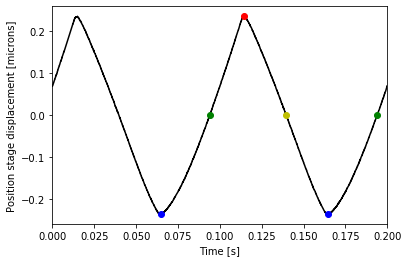

In [3316]:
#plotting displacement of the position stage (directly in microns already) versus time + pointing out extrema and points of zero crossing when the slope is positive and negative
# This serves as a visual control for the next step - calculating the slope of the triangular wave (AKA speed of the stage)
plt.plot(time, displac, 'black')
for i in range(len(up_indices)):
    plt.plot(time[up_indices[i]], 0, 'o', color='green') #mark relevant zero crossings (GREEN)
for i in range(len(down_indices)):
    plt.plot(time[down_indices[i]], 0, 'o', color='y') #mark relevant zero crossings (yellow)

for i in range(n_of_extrema):
    max_ind = maxima[i][0]
    max_voltage = maxima[i][1]

    min_ind = minima[i][0]
    min_voltage = minima[i][1]

    plt.plot(time[max_ind], max_voltage, 'o', color='red') #mark local QPD extreme (RED)
    plt.plot(time[min_ind], min_voltage, 'o', color='blue') #mark local QPD extreme (RED)

plt.xlim(time_display_start, time_display_stop)
plt.xlabel('Time [s]')
plt.ylabel('Position stage displacement [microns]')

slope (its abs. value) of this previous graph is the velocity of the position stage (and hence the water, upon neglecting any weird currents that could've formed)

In [3317]:
#Now I take the upwards and downwards sections individually and do a linear fit for each, averaging them in the end.
minima = np.array(minima)
maxima = np.array(maxima)

up_slopes = []
down_slopes = []

#if the first extremum is a minimum
if minima[0][0] < maxima[0][0]:
    start_index_up = 0
    start_index_down = 1
    print('starts with minimum')
elif minima[0][0] > maxima[0][0]:
    start_index_up = 1
    start_index_down = 0
    print('starts with maximum')
else:
     print('error')

for i in range(start_index_up, n_of_extrema, 2):
    rise = maxima[i, 1] - minima[i, 1] 
    run = (maxima[i, 0] - minima[i, 0])*(meas_len/n_of_datapoints)
    up_slope = rise/run
    up_slopes.append(up_slope)

for i in range(start_index_down, n_of_extrema, 2):
    rise = maxima[i, 1] - minima[i, 1] 
    run = (maxima[i, 0] - minima[i, 0])*(meas_len/n_of_datapoints)
    down_slope = rise/run
    down_slopes.append(down_slope)

starts with minimum


In [3318]:
# find the average slope of the triangular wave and print it
import statistics

avg_pos_up_slope = np.mean(up_slopes)
avg_pos_down_slope = np.mean(down_slopes)

up_pos_err = statistics.stdev(up_slopes)
down_pos_err = statistics.stdev(down_slopes)

stage_velocity = abs(np.average([avg_pos_up_slope, avg_pos_down_slope])) # microns per second
stage_velocity_err = np.mean([abs(up_pos_err), abs(down_pos_err)])
print(stage_velocity)
print(stage_velocity_err)

9.475694905448893
0.06876601999936321


# This is the stage velocity (microns per second) and its error (STDEV)

Text(0, 0.5, 'QPD signal [Volts]')

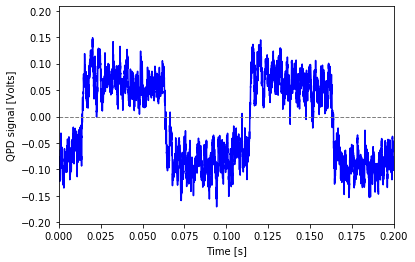

In [3319]:
#here I take the qpd data of interest, find the offset and shift it so it's centered around y = 0 (this comes from the difficulty of actually "zeroing" the qpd output perfectly)
#I do it here because I'm finding zero-crossings later and I want to prevent errors
square_offset = np.average(qpd_voltage)
qpd_voltage_centered = qpd_voltage - square_offset

plt.plot(time, qpd_voltage_centered, 'b')
plt.xlim(time_display_start, time_display_stop)
plt.axhline(y=0, linewidth=1, color='grey', linestyle = '--') #just a y=0 dashed line
plt.xlabel('Time [s]')
plt.ylabel('QPD signal [Volts]')

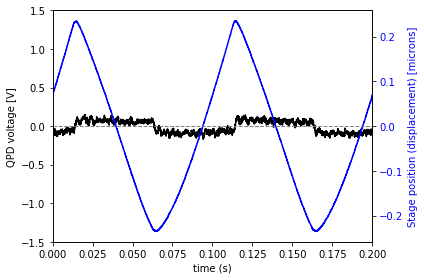

In [3320]:
# plot QPD voltage (versus time) and fixed bead displacement (microns vs time) on the same graph
#from here, it should be obvious what motion of the stage correspond to what bead "displacement voltage"
fig, ax1 = plt.subplots()

#qpd voltage part of the plot
ax1.set_xlabel('time (s)', color = 'black')
ax1.set_ylabel('QPD voltage [V]', color = 'black')
ax1.plot(time, qpd_voltage_centered, color = 'black')
ax1.tick_params(axis='y')
ax1.set_ylim(-1.5,1.5)

#x-displacement part of the plot
ax2 = ax1.twinx()
ax2.set_ylabel('Stage position (displacement) [microns]', color = 'blue')  # we already handled the x-label with ax1
ax2.plot(time, displac, color = 'blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.xlim(time_display_start,time_display_stop)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axhline(y=0, linewidth=1, color='grey', linestyle = '--')

plt.show()

The signals look this way for a specific reason:
we are sending a triangular signal to the position stage, meaning that it oscillates along one axis (X in this case) left and right at a steady speed.
QPD voltage data represents the bead's displacement from the trap's center. When the stage moves at a steady speed, the stoke's drag force will be equal to the trap's restoring force, and the bead will "hang" at a roughly constant displacemet position - that's why the qpd signal is roughly square rectangular, and change of sign occurs swiftly when the position stage motion changes direction

Now I want to find the typical (average) displacement of the bead from the center of the trap during one steady motion sweep of the stage (upper and lower flat parts of the square signal)

In [3321]:
qpd_zero_crossings = np.where(np.diff(np.sign(qpd_voltage_centered)))[0] #get an array of indices at which a sign change occurs in the qpd signal

In [3322]:
#I need to run hysteresis on the qpd square wave to delete redundant zero crossings - at least twice!
# that cleans up additional zero-crossing indices in the square QPD signal

qpd_zero_crossings = hysteresis(qpd_zero_crossings)
qpd_zero_crossings = hysteresis(qpd_zero_crossings)

In [3323]:
#after each qpd zero crossing, take all qpd values until the next zero crossing, average them and store the averages in an array (separate for upper and lower parts)

#find if the fisrt FULL segment is positive or negative and store "up" and "down" segments (movement left or right) accordingly
first_segment = [] 
for index in range(qpd_zero_crossings[0] + 1, qpd_zero_crossings[1] - 1):
    first_segment.append(qpd_voltage_centered[index])
first_segment_avg = np.average(first_segment)

edge = int(avg_diffs/3) #this is the number of datapoints that should be omitted at the beginning and end of each horizontal segment (due to the noise) + it takes a while for the bead to stabilize its position

up_avgs = []
up_STDEVs = []
down_avgs = []
down_STDEVs = []

if first_segment_avg > 0:
    for i in range(0, len(qpd_zero_crossings)-1, 2):
        up_segment = []
        for index in range(qpd_zero_crossings[i] + edge, qpd_zero_crossings[i+1] - edge):
            up_segment.append(qpd_voltage_centered[index])
        up_segment_avg = np.average(up_segment)
        up_segment_STDEV = statistics.stdev(up_segment)
        up_avgs.append(up_segment_avg)
        up_STDEVs.append(up_segment_STDEV)

    for i in range(1, len(qpd_zero_crossings)-1, 2):
        down_segment = []
        for index in range(qpd_zero_crossings[i] + edge, qpd_zero_crossings[i+1] - edge):
            down_segment.append(qpd_voltage_centered[index])
        down_segment_avg = np.average(down_segment)
        down_segment_STDEV = statistics.stdev(down_segment)
        down_avgs.append(down_segment_avg)
        down_STDEVs.append(down_segment_STDEV)
else:
    for i in range(1, len(qpd_zero_crossings)-1, 2):
        up_segment = []
        for index in range(qpd_zero_crossings[i] + edge, qpd_zero_crossings[i+1] - edge):
            up_segment.append(qpd_voltage_centered[index])
        up_segment_avg = np.average(up_segment)
        up_segment_STDEV = statistics.stdev(up_segment)
        up_avgs.append(up_segment_avg)
        up_STDEVs.append(up_segment_STDEV)

    for i in range(0, len(qpd_zero_crossings)-1, 2):
        down_segment = []
        for index in range(qpd_zero_crossings[i] + edge, qpd_zero_crossings[i+1] - edge):
            down_segment.append(qpd_voltage_centered[index])
        down_segment_avg = np.average(down_segment)
        down_segment_STDEV = statistics.stdev(down_segment)
        down_avgs.append(down_segment_avg)
        down_STDEVs.append(down_segment_STDEV)

for i in range(len(up_avgs)):
    up_avgs[i] = abs(up_avgs[i])
for i in range(len(down_avgs)):
    down_avgs[i] = abs(down_avgs[i])

qpd_up_avg = np.average(up_avgs)
qpd_down_avg = np.average(down_avgs)
qpd_displac_avg = np.average([abs(qpd_up_avg), abs(qpd_down_avg)]) #Volts. This is the average displacement of the bead (though measured in volts from QPD) during steady stage motion sweep
avg_STDEV_up = np.average(up_STDEVs)
avg_STDEV_down = np.average(down_STDEVs)

avg_STDEV = np.mean([abs(avg_STDEV_up), abs(avg_STDEV_down)])

print("AVG displacement: ", qpd_displac_avg, " microns")
print("STDEV: ", avg_STDEV, " microns")




AVG displacement:  0.07238719806023905  microns
STDEV:  0.029010470572498975  microns


# This is the average bead displacement at const. stage velocity (measured in QPD voltage!)

In [3324]:
# now I want to convert the average QPD bead displacement voltage into actual displacement in microns. That is dependent on the chosen laser power 
# and I thus need to bring in the sensitivity values obtained in another jupyter notebook!

qpd_laser_power_index = int(np.where(qpd_laser_powers == picked_power)[0])
qpd_sens = qpd_sens_avg[qpd_laser_power_index] #microns/volt
print(qpd_sens, " microns/volt qpd sensitivity at ", picked_power, " mA laser power")
displac_avg = qpd_displac_avg * qpd_sens # volt*microns/volt
print(displac_avg, " microns avg. bead displacement")

0.01832054840813346  microns/volt qpd sensitivity at  400  mA laser power
0.001326173166191754  microns avg. bead displacement


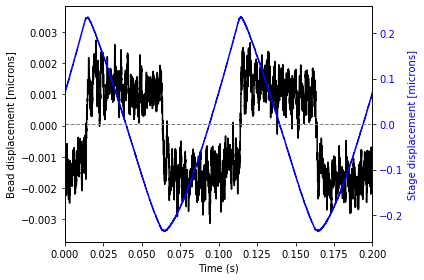

In [3325]:
#Now I just plot both the bead displacement and stage displacement
fig, ax1 = plt.subplots()

#qpd voltage part of the plot
ax1.set_xlabel('Time (s)', color = 'black')
ax1.set_ylabel("Bead displacement [microns]", color = 'black')
ax1.plot(time, qpd_voltage_centered*qpd_sens, color = 'black')
ax1.tick_params(axis='y')

#x-displacement part of the plot
ax2 = ax1.twinx()
ax2.set_ylabel('Stage displacement [microns]', color = 'blue')  # we already handled the x-label with ax1
ax2.plot(time, displac, color = 'blue')
ax2.tick_params(axis='y', labelcolor = 'blue')
plt.xlim(time_display_start,time_display_stop)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axhline(y=0, linewidth=1, color='grey', linestyle = '--')

plt.show()

In [3326]:
#Now I use this to calculate the stokes force and trap stiffness:
def get_stiffness(viscosity, viscosity_err, bead_diameter, diam_err, stage_velocity, velocity_err, bead_displacement, displacement_STDEV): 
    stiffness = 3 * np.pi * viscosity * bead_diameter * stage_velocity / bead_displacement
    stiffness_ERR = np.sqrt((viscosity_err/viscosity)**2 + (diam_err/bead_diameter)**2 + (velocity_err/stage_velocity)**2 + (bead_displacement/displacement_STDEV)**2)*stiffness
    return(stiffness, stiffness_ERR) #returns stifness in pN/micron

In [3327]:
[trap_stiffness, stiffness_ERR] = get_stiffness(viscosity, viscosity_err, bead_diameter, bead_diam_err, stage_velocity, stage_velocity_err, displac_avg, avg_STDEV)
print(trap_stiffness)
print(stiffness_ERR)

64.24366887858547
9.770532634298485


# This is the trap stiffness (pN/micron)! and its error (STDEV)

here I'm using the excel file with the QPD sensitivities and write in the stiffness for specific laser power and bead diameter.

In [3328]:
import xlsxwriter
import openpyxl

# python sucks and I can't write into an existing file that easily so I need to do the following:
write_file = openpyxl.load_workbook(workbook_name) #handler for writing into an existing excel file
sheet = write_file.get_sheet_by_name(sheet_name) #get the name of the existing sheet

power_index = np.where(qpd_laser_powers == picked_power)[0][0] #find the index of the laser power used
sheet.cell(row=power_index+2, column=3).value = trap_stiffness #write the average qpd sensitivity value next to the relevant laser power
sheet.cell(row=power_index+2, column=6).value = stiffness_ERR #write the average stiffness error

write_file.save(workbook_name) #save the excel file

ipykernel_launcher:6: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
